In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
import re
import pandas as pd
import numpy as np
import gc
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from matplotlib_venn import venn2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [103]:
train_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/train_data.csv')
test_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/test_data.csv')

### preprocessing

In [104]:
# targetを使用したもの
# category_id
category_mean_ = train_df[["categoryId", "y"]].groupby("categoryId").mean().reset_index().rename({"y":"category_mean"}, axis=1)
category_max_ = train_df[["categoryId", "y"]].groupby("categoryId").max().reset_index().rename({"y":"category_max"}, axis=1)
category_min_ = train_df[["categoryId", "y"]].groupby("categoryId").min().reset_index().rename({"y":"category_min"}, axis=1)
category_std_ = train_df[["categoryId", "y"]].groupby("categoryId").std().reset_index().rename({"y":"category_std"}, axis=1)
category_count_ = train_df[["categoryId", "y"]].groupby("categoryId").count().reset_index().rename({"y":"category_count"}, axis=1)
category_q1_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.1).reset_index().rename({"y":"category_q1"}, axis=1)
category_q25_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.25).reset_index().rename({"y":"category_q25"}, axis=1)
category_q5_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.5).reset_index().rename({"y":"category_q5"}, axis=1)
category_q75_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.75).reset_index().rename({"y":"category_q75"}, axis=1)
category_q9_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.9).reset_index().rename({"y":"category_q9"}, axis=1)
# c

In [105]:
train_y = train_df['y']
del train_df["y"]

In [106]:
df = pd.concat([train_df, test_df])

In [107]:
# merge
df = df.merge(category_mean_, how='left', on=["categoryId"])
df = df.merge(category_max_, how='left', on=["categoryId"])
df = df.merge(category_min_, how='left', on=["categoryId"])
df = df.merge(category_std_, how='left', on=["categoryId"])
#df = df.merge(count_, how='left', on=["categoryId"])
df = df.merge(category_q1_, how='left', on=["categoryId"])
df = df.merge(category_q25_, how='left', on=["categoryId"])
df = df.merge(category_q5_, how='left', on=["categoryId"])
df = df.merge(category_q75_, how='left', on=["categoryId"])
df = df.merge(category_q9_, how='left', on=["categoryId"])

In [108]:
# channelId
le_channelId = LabelEncoder()
df['channelId'] = le_channelId.fit_transform(df['channelId'])

In [109]:
# drop id , video_id  and thumbnail_link
del df['id']
del df['video_id']
del df['thumbnail_link']

In [110]:
# publishedAt
df["publishedAt"] = pd.to_datetime(df["publishedAt"])
df["year"] = df["publishedAt"].dt.year
df["month"] = df["publishedAt"].dt.month
df["day"] = df["publishedAt"].dt.day
df["hour"] = df["publishedAt"].dt.hour
df["minute"] = df["publishedAt"].dt.minute
del df["publishedAt"]

In [111]:
# collection_date
df["collection_date"] = "20" + df["collection_date"]
df["collection_date"] = pd.to_datetime(df["collection_date"], format="%Y.%d.%m")
df["c_year"] = df["collection_date"].dt.year
df["c_month"] = df["collection_date"].dt.month
df["c_day"] = df["collection_date"].dt.day
del df["collection_date"]

In [112]:
# like and dislikes
df['evaluation'] = df['likes'] + df['dislikes']
df['eval_by_comment'] = df['evaluation'] * df['comment_count']
df["logdislikes"] = np.log(df["dislikes"]+1)
df["logcomment_count"] = np.log(df["comment_count"]+1)
df["sqrtlikes"] = np.sqrt(df["likes"])
df["like_dislike_ratio"] = df["likes"]/(df["dislikes"]+1)
df["comments_like_ratio"] = df["comment_count"]/(df["likes"]+1)
df["comments_dislike_ratio"] = df["comment_count"]/(df["dislikes"]+1)
# likes comments diable
df["likes_com"] = df["likes"] * df["comments_disabled"]
df["dislikes_com"] = df["dislikes"] * df["comments_disabled"]
df["comments_likes"] = df["comment_count"] * df["ratings_disabled"]

In [113]:
#channel TItle
channel_title_doct = df['channelTitle'].value_counts().to_dict()
df['channelTItle_count'] = df['channelTitle'].apply(lambda x: channel_title_doct[x] if x in channel_title_doct else 0)

In [114]:
# length_tags
df["tags"].fillna("[none]", inplace=True)
df["num_tags"] = df["tags"].astype(str).apply(lambda x: len(x.split("|")))
df["length_tags"] = df["tags"].astype(str).apply(lambda x: len(x))

In [115]:
# title
df['official']  = df['title'].apply(lambda x: True if 'Official' in x else False)
df['title_length'] = df['title'].apply(lambda x: len(x))

In [116]:
# description
df["description"].fillna(" ", inplace=True)
df["ishttp_in_dis"] = df["description"].apply(lambda x: x.lower().count("http"))
df["len_description"] = df["description"].apply(lambda x: len(x))
df["conEn_title"] = df["title"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
df["conEn_tags"] = df["tags"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
df["conEn_description"] = df["description"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))

In [117]:
df.head(4)

,title,channelId,channelTitle,categoryId,tags,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_mean,category_max,category_min,category_std,category_q1,category_q25,category_q5,category_q75,category_q9,year,month,day,hour,minute,c_year,c_month,c_day,evaluation,eval_by_comment,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,channelTItle_count,num_tags,length_tags,official,title_length,ishttp_in_dis,len_description,conEn_title,conEn_tags,conEn_description
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,7498,DjangoShiny,20,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,1.110494e+06,1.953992e+07,48.0,2.052324e+06,30670.4,121542.25,433934.5,1162340.25,2603043.6,2011,1,9,5,50,2020,2,1,114,798,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,1,48,315,False,42,0,61,19,258,38
1,ねごと - メルシールー [Official Music Video],12289,ねごと Official Channel,10,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,7.109256e+06,1.302070e+09,6.0,4.440962e+07,29644.2,119623.50,560720.0,2306314.75,8221974.9,2012,7,23,3,0,2020,2,8,2935,325785,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,5,19,129,True,35,1,261,18,38,54
2,VF3tb 闇よだれvsちび太 (SEGA),3392,siropai,24,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,2.154325e+06,2.271761e+08,3.0,7.964865e+06,17748.0,78524.00,358451.0,1416473.00,4313006.0,2007,7,26,13,54,2020,1,14,150,2100,2.890372,2.708050,11.532563,7.388889,0.104478,0.777778,0,0,0,1,9,52,False,22,1,45,11,33,36
3,free frosty weekend!,2243,Jones4Carrie,22,frosty,287,51,173,False,False,I look so bad but look at me!,1.352693e+06,4.178697e+07,8.0,3.811351e+06,3979.8,38162.00,198158.0,942131.50,3289791.0,2005,5,15,2,38,2019,12,22,338,58474,3.951244,5.159055,16.941074,5.519231,0.600694,3.326923,0,0,0,10,1,6,False,20,0,30,17,6,21


In [118]:
# 言語処理はあとで行う
df = df.drop(["title","channelTitle","tags","description"], axis=1)

In [119]:
df.head(2)

,channelId,categoryId,likes,dislikes,comment_count,comments_disabled,ratings_disabled,category_mean,category_max,category_min,category_std,category_q1,category_q25,category_q5,category_q75,category_q9,year,month,day,hour,minute,c_year,c_month,c_day,evaluation,eval_by_comment,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,channelTItle_count,num_tags,length_tags,official,title_length,ishttp_in_dis,len_description,conEn_title,conEn_tags,conEn_description
0,7498,20,114,0,7,False,False,1.110494e+06,1.953992e+07,48.0,2.052324e+06,30670.4,121542.25,433934.5,1162340.25,2603043.6,2011,1,9,5,50,2020,2,1,114,798,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,1,48,315,False,42,0,61,19,258,38
1,12289,10,2885,50,111,False,False,7.109256e+06,1.302070e+09,6.0,4.440962e+07,29644.2,119623.50,560720.0,2306314.75,8221974.9,2012,7,23,3,0,2020,2,8,2935,325785,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,5,19,129,True,35,1,261,18,38,54


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49302 entries, 0 to 49301
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channelId               49302 non-null  int64  
 1   categoryId              49302 non-null  int64  
 2   likes                   49302 non-null  int64  
 3   dislikes                49302 non-null  int64  
 4   comment_count           49302 non-null  int64  
 5   comments_disabled       49302 non-null  bool   
 6   ratings_disabled        49302 non-null  bool   
 7   category_mean           49293 non-null  float64
 8   category_max            49293 non-null  float64
 9   category_min            49293 non-null  float64
 10  category_std            49293 non-null  float64
 11  category_q1             49293 non-null  float64
 12  category_q25            49293 non-null  float64
 13  category_q5             49293 non-null  float64
 14  category_q75            49293 non-null

In [121]:
# データの分割
train = df.iloc[:len(train_y), :]
test = df.iloc[len(train_y):, :]

In [122]:
# kfold
cv = KFold(n_splits=5, shuffle=True, random_state=2020)
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 20,
    'learning_rate': 0.01,
    "n_jobs": -1,
    "verbose": -1,
    # "max_depth":4,
    # "max_bin": 128,
    # "bagging_fraction":0.5,
    # "lambda_l1":0.1,
    # "lambda_l2":0.04
    # "subsample":0.7, 
    # "colsample_bytree":0.7
}
# params = {'task': 'train',
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         "seed":42,
#         'learning_rate': 0.01,}
# best_params =  {'lambda_l1': 0.019918875912078603,
#                 'lambda_l2': 0.002616688073257713,
#                 'num_leaves': 219, 
#                 'feature_fraction': 0.6641013611124621,
#                 'bagging_fraction': 0.7024199018549259,
#                 'bagging_freq': 5, 
#                 'min_child_samples': 5}

# params.update(best_params)

In [123]:
y = np.log(train_y)
pred =0
score = 0
c =0 

###  training(lgb)

In [124]:
for tr_idx, val_idx in cv.split(train):
    x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
    y_train, y_val = y[tr_idx], y[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=30000, early_stopping_rounds=1000, 
                      valid_sets=[train_set, val_set], verbose_eval=500)
    
    # 予測したらexpで元に戻す
    test_pred = np.exp(model.predict(test))
    # 0より小さな値があるとエラーになるので補正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred += test_pred / 5  #  5fold回すので

    oof = np.exp(model.predict(x_val))
    oof = np.where(oof < 0, 0, oof)
    rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), oof))
    c += 1
    print("{}回目の思考".format(c))
    print(f"RMSLE : {rmsle}")
    score += rmsle/ 5

Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.725496	valid_1's rmse: 0.822978
[1000]	training's rmse: 0.643876	valid_1's rmse: 0.799541
[1500]	training's rmse: 0.592089	valid_1's rmse: 0.79314
[2000]	training's rmse: 0.551079	valid_1's rmse: 0.790146
[2500]	training's rmse: 0.514307	valid_1's rmse: 0.787748
[3000]	training's rmse: 0.482104	valid_1's rmse: 0.785966
[3500]	training's rmse: 0.453781	valid_1's rmse: 0.78443
[4000]	training's rmse: 0.428859	valid_1's rmse: 0.78349
[4500]	training's rmse: 0.405572	valid_1's rmse: 0.78348
[5000]	training's rmse: 0.38426	valid_1's rmse: 0.78307
[5500]	training's rmse: 0.366148	valid_1's rmse: 0.783026
[6000]	training's rmse: 0.348504	valid_1's rmse: 0.782885
[6500]	training's rmse: 0.331273	valid_1's rmse: 0.783345
Early stopping, best iteration is:
[5999]	training's rmse: 0.348525	valid_1's rmse: 0.782884
1回目の思考
RMSLE : 0.7821034925506275
Training until validation scores don't improve for 1000 rounds

###  training(xgb)

In [ ]:
# xgb_pram = {
    
# }

In [ ]:
# gscv = xgb.XGBRegressor(n_estimators=50000, learning_rate=0.01, max_depth=6, subsample=0.7, colsample_bytree=0.7)
# for tr_idx, val_idx in cv.split(train):
#     x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
#     y_train, y_val = y[tr_idx], y[val_idx]
    
#     gscv.fit(x_train, y_train)
#     # 予測したらexpで元に戻す
#     test_pred = np.exp(gscv.predict(test))
#     # 0より小さな値があるとエラーになるので補正
#     test_pred = np.where(test_pred < 0, 0, test_pred)
#     pred += test_pred / 5  #  5fold回すので

#     oof = np.exp(gscv.predict(x_val))
#     oof = np.where(oof < 0, 0, oof)
#     rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), oof))
#     print(f"RMSLE : {rmsle}")
#     score += rmsle/ 5


## eval

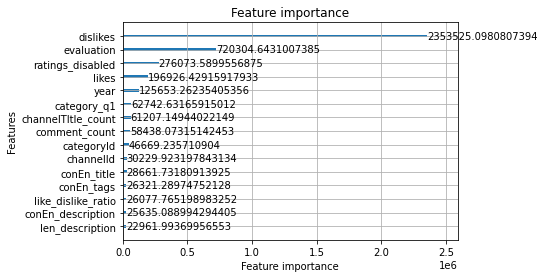

In [125]:
lgb.plot_importance(model, importance_type="gain", max_num_features=15)

In [126]:
print(f"Mean RMSLE SCORE :{score}")

Mean RMSLE SCORE :0.7825467782969366


In [127]:
submit_df = pd.DataFrame({"y": pred})
submit_df.index.name = "id"
submit_df.to_csv("submit.csv")

In [128]:
from google.colab import files
files.download('submit.csv')

nlp

In [19]:
nlp_df = train_df['description']